In [1]:
# import stuff

import numpy as np
import math as m
import pandas as pd
import matplotlib.pyplot as plt
import os
os.chdir('C:\\Users\\nicol\\Desktop\\pythonfiles\\micrometereology\\04')

from windrose import WindroseAxes
from scipy.optimize import minimize
from scipy.special import gamma
from scipy.integrate import quad
import matplotlib.patches as patches
from matplotlib.patches import Rectangle


In [54]:
def compute_Weibull_parameters(array):
    mean = np.mean(array)
    variance = np.var(array)

    # Define a function to calculate the moments of the Weibull distribution
    def weibull_moments(params):
        k, lambd = params
        mu = lambd * gamma(1 + 1/k)
        m2 = (lambd**2 * gamma(1 + 2/k)) - mu**2
        return np.array([mu, m2])

    #Define a function to calculate the difference between observed and estimated moments
    def moment_error(params):
        observed_moments = np.array([mean, variance])
        estimated_moments = weibull_moments(params)
        return np.sum((observed_moments - estimated_moments)**2)

    # Initial guesses for k and lambd
    initial_guess = [1.0, 1.0]

    # Minimize the error function to estimate parameters
    result = minimize(moment_error, initial_guess, method='Nelder-Mead')

    # Extract estimated parameters
    estimated_k, estimated_lambda = result.x

    return(estimated_k,estimated_lambda)


def compute_Weibull(array):
    k, lam = compute_Weibull_parameters(array)

    x = np.linspace(0.01, max(array), num=len(array))
    #x = np.sort(array)
    y = k/x * (x / lam)**k * np.exp(-(x/lam)**k)

    array_name = [name for name, value in globals().items() if value is array][0]
    plt.plot(x, y)
    print(f'for {array_name}: k = {k:.2f} and lam = {lam:.2f}')


def plot_histogram(array_data, num, color, label):
    # plots the histogram of an array of data
    x = np.linspace(min(array_data), max(array_data), num=num)
    y = np.histogram(array_data, bins=num, density=True)
    delta = num/10000
    width_bar = (max(array_data) - min(array_data)) / num + delta
    #width_bar = (max(array_data) - min(array_data)) / num
    plt.bar(x, y[0], width=width_bar, align='center', color=color, label=label)
    area = np.sum(y[0]*(width_bar))
    area = np.sum(y[0]*(width_bar-delta))
    print(f"area under graph = {area:.5f}")

def plot_Weibull(array_data, k, lam, color, label):
    # computes the Weibull distribution given k and lamda and plots it in the range of the data to avoid zeros
    x = np.linspace(0.001, max(array_data), num=100)
    y = k/x * (x / lam)**k * np.exp(-(x/lam)**k)
    plt.plot(x, y, color=color, label=label)



def divide_in_sector(velocity, direction, time):
    # divides velocity in 12 sectors, from 0 at 0° to 11 at 330°
    # return matrix with shape [[],[],[],[],[],[],[],[],[],[],[],[]]
    indices = np.argsort(direction)[::-1]

    V_sorted = velocity[indices]
    dir_sorted = direction[indices]
    time_sorted = time[indices]

    data_sector = [[],[],[],[],[],[],[],[],[],[],[],[]]
    for j in range(1, len(data_sector)):
        for i in range(len(dir_sorted)):
            low = (j - 1) * 30 + 15
            high = (j) * 30 + 15
            if low <= dir_sorted[i] < high:
                data_sector[j].append(V_sorted[i])
    for i in range(len(dir_sorted)):
        if dir_sorted[i] < 15 or dir_sorted[i] >= 345:
            data_sector[0].append(V_sorted[i])

    return data_sector


def Weibull(U, k, A):
    y = k/U * (U/A)**k * np.exp(-(U/A)**k)
    return y

def compute_u_star_waterland(G, fc, z0land, z0water, A, B, eps, max_iteration):
    # computes iteratively the u_star given the geostrophic wind
    u_star, u_star_new = 1, 1
    kk, count = 0,0

    while kk==0:
        count += 1
        u_star = u_star_new
        u_star_new =  G*k /np.sqrt((np.log((u_star/fc)/z0land) - A)**2 + B**2)

        if abs(u_star_new - u_star) < eps:
            kk=1
        if count > max_iteration:
            kk=1
            print(f'not convergent: ustar: new ={u_star_new:.4f}, old = {u_star:.4f}')
    return u_star_new

def transfer_wind(land_direction, data, k, fc, A, B, z0water, z0land):
    # from the velocity at 70m computes u_star, G, u_star of the new locarion, U120 at the new location
    # return matrix with shape [[],[],[],[],[],[],[],[],[],[],[],[]]

    data_new = []
    for i in range(len(data)):
        U120_array = []
        if i in land_direction:
            for U in data[i]:
                if U > 0:
                    u_star = U*k*1/np.log(70/z0water)
                    G = u_star/k * np.sqrt((np.log((u_star/fc)/z0water) - A)**2 + B**2)
                    u_star_new = compute_u_star_waterland(G=G, fc=fc, z0land=z0land, z0water=z0water, A=A, B=B, eps=eps, max_iteration=max_iteration)
                    U120 = u_star_new/k*np.log(120/z0land)
                else:
                    U120 = 0
                U120_array.append(U120)
        else:
            U120_array = data[i]
        data_new.append(np.array(U120_array))
    return data_new

def transfer_wind_up(data, k, fc, A, B, z0water, z0land):
    # from velocity at 70m computes u_star, U120 at the same location
    data_new = []
    for i in range(len(data)):
        u_star = np.array(data[i])*k*1/np.log(70/z0water)
        U120 = u_star/k*np.log(120/z0water)
        data_new.append(U120)
    return data_new

def compute_AEP(data_sector, Prated, Urp, Ucutoff, T, Umax, num):
    # computes AEP given data divided in the 12 sectors. for each sector the weibul parameters are calcolated
    E = []
    U_array = np.linspace(0.01,Umax, num=num1)
    total = sum(len(sublist) for sublist in data_sector)
    i = 0
    for sector in data_sector:
        fi = len(sector)/total

        wei_k, wei_A = compute_Weibull_parameters(sector)
        #print(f'for sector {i:2.0f}: f = {fi:.4f}, wei-k = {wei_k:.2f} and wei-A = {wei_A :.2f}')

        integral = 0

        for U in U_array:
            y1 = Weibull(U, wei_k, wei_A)
            if U <= Urp:
                y2 = Prated*(U/Urp)**3
            elif Urp < U <=Ucutoff:
                y2 = Prated
            else:
                y2 = 0
            rect = y1*y2*Umax/num1
            integral = integral + rect
        
        E.append(T*fi*integral)
        i = i+1
    AEP = np.sum(E)
    return AEP, E

def divide_in_year_january(V_array, time_array, dir_array):
    # divides given velocity and direction by year, starting the year in january
    tot_velocities = len(V_array)

    velocity_by_year = {}
    direction_by_year = {}

    for i in range(len(V_array)):
        year = int(time_array[i] // 100000000)

        if year not in velocity_by_year:
            velocity_by_year[year] = []
            direction_by_year[year] = []
        velocity_by_year[year].append(V_array[i])
        direction_by_year[year].append(dir_array[i])
    return velocity_by_year, direction_by_year

def divide_in_year_september(V_array, time_array, dir_array):
    # divides given velocity and direction by year, starting the year in semptember
    velocity_by_year = {}
    direction_by_year = {}
    time_by_year = {}

    for i in range(len(V_array)):
        year = int(time_array[i] // 100000000)
        month = int(str(time_array[i])[4:6])

        if year not in velocity_by_year:
            velocity_by_year[year] = []
            direction_by_year[year] = []
            time_by_year[year] = []

        if month >= 9:
            velocity_by_year[year].append(V_array[i])
            direction_by_year[year].append(dir_array[i])
            time_by_year[year].append(time_array[i])
        else:
            velocity_by_year[year-1].append(V_array[i])
            direction_by_year[year-1].append(dir_array[i])
            time_by_year[year-1].append(time_array[i])
    return velocity_by_year, direction_by_year, time_by_year




In [27]:
# DATA

data = pd.read_csv('sprog.tsv', delimiter='\t', header=None, 
                    names=['t','V','dir67', 'dir70'])

time_all = data['t'].values
V_all = data['V'].values
dir67_all = data['dir67'].values
dir70_all = data['dir70'].values

V_array = []
dir_array = []
time_array = []
for i in range(len(V_all)):
    if V_all[i] < 90:
        if dir67_all[i] < 900:
            V_array.append(V_all[i])
            dir_array.append(dir67_all[i])
            time_array.append(time_all[i])
        elif dir70_all[i] < 900:
            V_array.append(V_all[i])
            dir_array.append(dir70_all[i])
            time_array.append(time_all[i])

V_array = np.array(V_array)
dir_array = np.array(dir_array)
time_array = np.array(time_array)

num=100
Prated = 13*10**6
Urp = 12
Ucutoff = 25
Umax = 30
num1 = 10000
T = 24*365

land_west = [7,8,9,10]
land_east = [1,2,3,4]

k = 0.4
z0water = 2*10**-4
z0land = 2.5*10**-2
z120 = 120
z70 = 70

phi = 55.33
omegaE = 7.2921*10**-5
fc = 2*omegaE*np.sin(np.deg2rad(phi))
A = 1.8
B = 4.5

eps = 1e-2
max_iteration = 10000





for V_array: k = 2.23 and lam = 9.29
area under graph = 1.00000


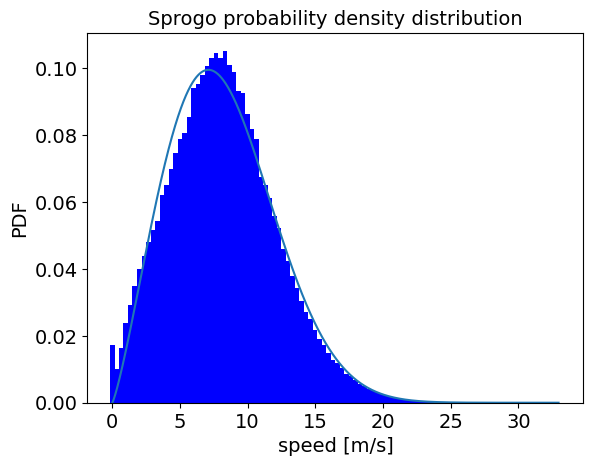

In [41]:
# show distribution
compute_Weibull(V_array)
plot_histogram(array_data=V_array, num=num, color='b', label='Histrogram')
plt.title("Sprogo probability density distribution")
plt.xlabel("speed [m/s]")
plt.ylabel("PDF")
plt.show()

Text(0.5, 1.0, 'All data')

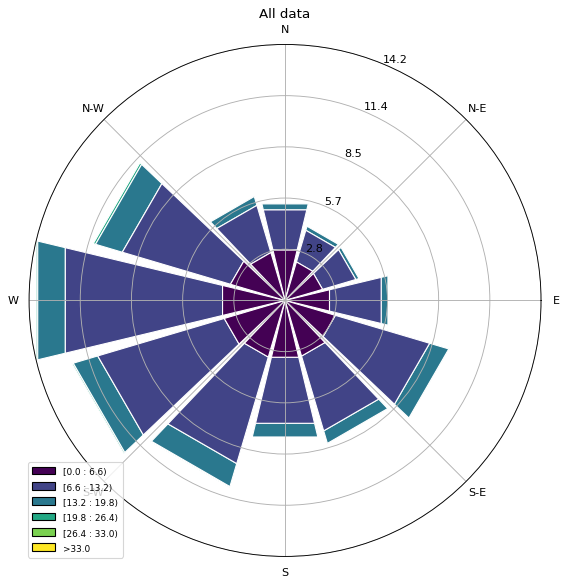

In [30]:
# WIND ROSE

ax = WindroseAxes.from_ax()
ax.bar(dir_array, V_array, normed=True, opening=0.9, edgecolor='white', nsector=12)
ax.set_legend()
ax.set_title('All data')

maximum AEP  = 113.88 [GWh]
computed AEP =  46.55 [GWh]


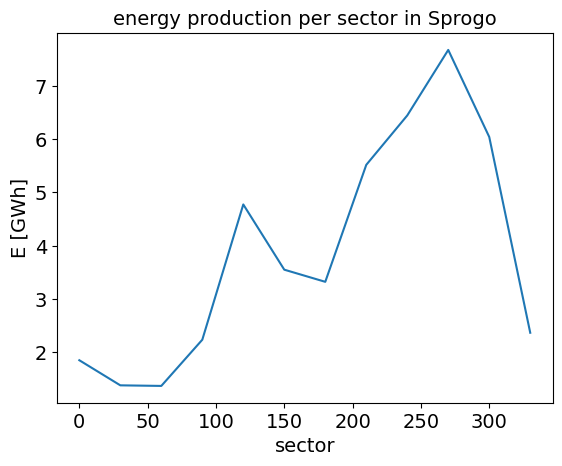

In [42]:
# COMPUTE AEP at 70 m in Sprogo

data_sector = divide_in_sector(velocity=V_array, direction=dir_array, time=time_array)

AEP_tot, E_tot =  compute_AEP(data_sector=data_sector, Prated=Prated, Urp=Urp, Ucutoff=Ucutoff, Umax=Umax, T=T, num=num1)
print(f'maximum AEP  = {T*Prated/10**9:6.2f} [GWh]')
print(f'computed AEP = {AEP_tot/10**9:6.2f} [GWh]')

direction = np.arange(0, 360, 30)
plt.plot(direction, np.array(E_tot)/10**9)
plt.title('energy production per sector in Sprogo')
plt.ylabel('E [GWh]')
plt.xlabel('sector')

plt.show()

In [37]:
# trasnfer data

#data_sector = divide_in_sector(velocity=V_array, direction=dir_array, time=time_array)

print(f'maximum AEP  = {T*Prated/10**9:6.2f} [GWh]')

data_center =  transfer_wind_up(data=data_sector, k=k, fc=fc, A=A, B=B, z0water=z0water, z0land=z0land)
AEP_center, E_center =  compute_AEP(data_sector=data_center, Prated=Prated, Urp=Urp, Ucutoff=Ucutoff, Umax=Umax, T=T, num=num1)

data_west =  transfer_wind(land_direction=land_west, data=data_sector, k=k, fc=fc, A=A, B=B, z0water=z0water, z0land=z0land)
AEP_west, E_west =  compute_AEP(data_sector=data_west, Prated=Prated, Urp=Urp, Ucutoff=Ucutoff, Umax=Umax, T=T, num=num1)

data_east =  transfer_wind(land_direction=land_east, data=data_sector, k=k, fc=fc, A=A, B=B, z0water=z0water, z0land=z0land)
AEP_east, E_east =  compute_AEP(data_sector=data_east, Prated=Prated, Urp=Urp, Ucutoff=Ucutoff, Umax=Umax, T=T, num=num1)

print(f'center AEP = {AEP_center/10**9:6.2f} [GWh]')
print(f'west AEP = {AEP_west/10**9:6.2f} [GWh]')
print(f'east AEP = {AEP_east/10**9:6.2f} [GWh]')



maximum AEP  = 113.88 [GWh]
center AEP =  49.89 [GWh]
west AEP =  42.90 [GWh]
east AEP =  45.05 [GWh]


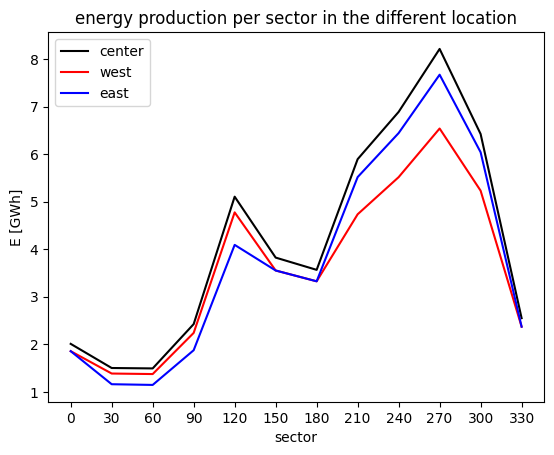

In [39]:
# graphical representation

direction = np.arange(0, 360, 30)
ticks_position = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]

plt.figure()
plt.plot(direction, np.array(E_center)/10**9, color='k', label='center')
plt.plot(direction, np.array(E_west)/10**9, color='r', label='west')
plt.plot(direction, np.array(E_east)/10**9, color='b', label='east')
plt.title('energy production per sector in the different location')
plt.ylabel('E [GWh]')
plt.xlabel('sector [°]')

plt.xticks(ticks_position)

plt.legend()
plt.show()

sorted by frequency
freq [ 1052 29811 41233 41441 48389 49992 50718 51609 51998 52176 52202 52385
 52455 52517 52528 52530 52530 52541 52544 52547 52554 52662 52690]
year [1999 1988 1987 1979 1981 1980 1977 1982 1994 1978 1992 1993 1996 1995
 1984 1985 1986 1989 1998 1990 1997 1983 1991]
mean [5.72352662 8.23418839 8.67016516 8.20384909 7.5304253  8.89696972
 8.15757818 8.34318549 8.83277203 8.60664616 8.32238497 8.27365792
 7.85649948 7.5693663  8.01146646 8.10253436 8.23394365 8.1357005
 8.01920276 7.81183893 8.44969536 8.51661046 8.28568969]

average of measurements per year: 47874
data excluded:       5.72, 8.23 [m/s]
for the year :       1999, 1988
having measurements: 1052, 29811
average elements per year without outliars= 50963

max average speed of 8.90 [m/s] for year 1980
min average speed of 7.53 [m/s] for year 1981


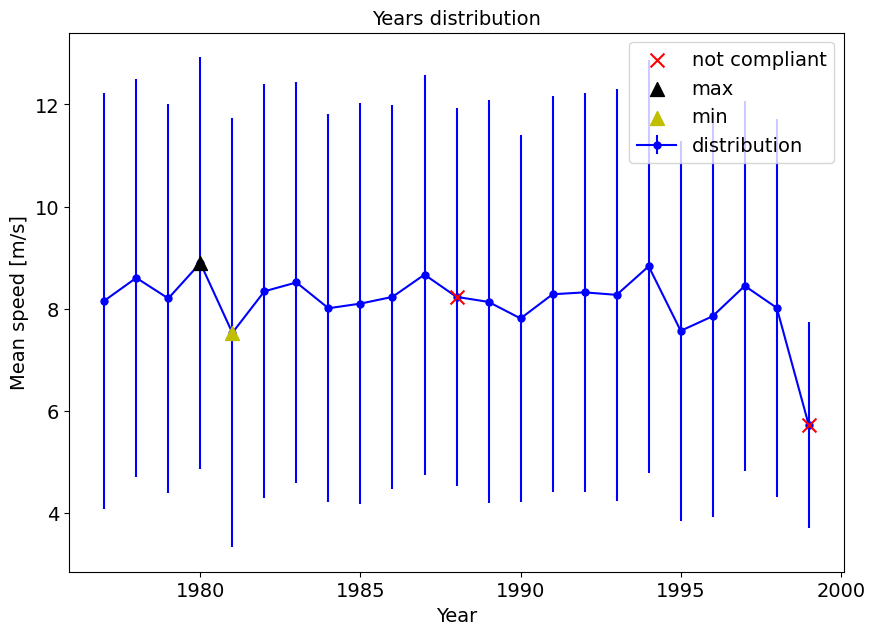

In [40]:
# find most and least windy year
# data in Sprogo 70 m

velocity_by_year, direction_by_year,time_by_year  = divide_in_year_september(V_array, time_array, dir_array)

year_array = []
mean_array = []
std_array = []
freq_array = []

for year, velocities in velocity_by_year.items():
    mean_velocity = np.mean(velocities)
    std_velocity = np.std(velocities)
    freq_velocity = len(velocities)
    year_array.append(year)
    mean_array.append(mean_velocity)
    std_array.append(std_velocity)
    freq_array.append(freq_velocity)

year_array = np.array(year_array)
mean_array = np.array(mean_array)
std_array = np.array(std_array)
freq_array = np.array(freq_array)

indices_byfreq = np.argsort(freq_array)[::]
year_sort = year_array[indices_byfreq]
mean_sort = mean_array[indices_byfreq]
freq_sort = freq_array[indices_byfreq]

print('sorted by frequency')
print('freq',freq_sort)
print('year', year_sort)
print('mean',mean_sort)


print('')
print(f'average of measurements per year: {int(np.mean(freq_sort)):.0f}')
print(f'data excluded:       {mean_sort[0]:.2f}, {mean_sort[1]:.2f} [m/s]')
print(f'for the year :       {year_sort[0]:.0f}, {year_sort[1]:.0f}')
print(f'having measurements: {freq_sort[0]:.0f}, {freq_sort[1]:.0f}')

# remove the year with too few data
year_sort1 = year_sort[2:]
mean_sort1 = mean_sort[2:]
freq_sort1 = freq_sort[2:]
print(f'average elements per year without outliars= {int(np.mean(freq_sort1)):.0f}')

max_index = np.argmax(mean_sort1)
min_index = np.argmin(mean_sort1)
max_value = mean_sort1[max_index]
min_value = mean_sort1[min_index]
max_year = year_sort1[max_index]
min_year = year_sort1[min_index]

print('')
print(f'max average speed of {max_value:.2f} [m/s] for year {max_year}')
print(f'min average speed of {min_value:.2f} [m/s] for year {min_year}')

plt.figure(1, figsize=(10,7))
plt.rc('font', size=14)
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)

plt.errorbar(x=year_array, y=mean_array, yerr=std_array, marker='o', markersize=5, color='b', zorder=1, label='distribution')
plt.scatter(x=year_sort[0:2], y=mean_sort[0:2],         marker='x', s=100, color='r', zorder=2, label='not compliant')
plt.scatter(x=max_year, y=max_value,                    marker='^', s=100, color='k',zorder=2, label='max')
plt.scatter(x=min_year, y=min_value,                    marker='^', s=100, color='y',zorder=2, label='min')

plt.legend()
plt.title('Years distribution')
plt.ylabel('Mean speed [m/s]')
plt.xlabel('Year')
plt.show()


center AEP =  49.89 [GWh]
AEP max west=  48.90 [GWh], difference of   2.00%
AEP max east=  51.25 [GWh], difference of   2.72%
AEP min west=  37.12 [GWh], difference of  25.61%
AEP min east=  39.10 [GWh], difference of  21.64%


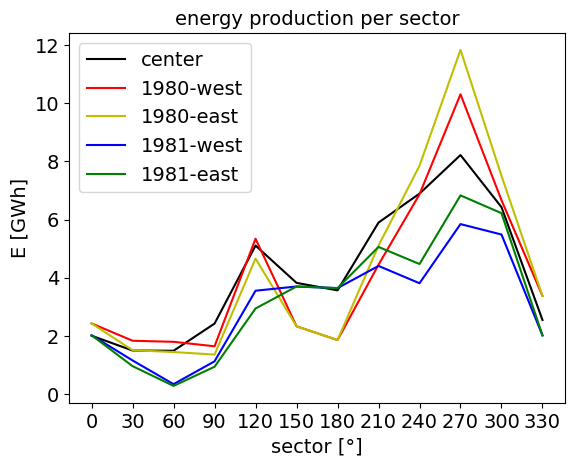

In [53]:
# AEP of most and least windy years at west and east 
# most: 1980
# least: 1981

V_array_max = np.array(velocity_by_year[1980])
dir_array_max = np.array(direction_by_year[1980])
time_array_max = np.array(time_by_year[1980])

data_max = divide_in_sector(velocity=V_array_max, direction=dir_array_max, time=time_array_max)
data_max_west =  transfer_wind(land_direction=land_west, data=data_max, k=k, fc=fc, A=A, B=B, z0water=z0water, z0land=z0land)
AEP_max_west, E_max_west =  compute_AEP(data_sector=data_max_west, Prated=Prated, Urp=Urp, Ucutoff=Ucutoff, T =T, Umax=Umax, num=num1)

data_max_east =  transfer_wind(land_direction=land_east, data=data_max, k=k, fc=fc, A=A, B=B, z0water=z0water, z0land=z0land)
AEP_max_east, E_max_east =  compute_AEP(data_sector=data_max_east, Prated=Prated, Urp=Urp, Ucutoff=Ucutoff, T =T, Umax=Umax, num=num1)


V_array_min = np.array(velocity_by_year[1981])
dir_array_min = np.array(direction_by_year[1981])
time_array_min = np.array(time_by_year[1981])

data_min = divide_in_sector(velocity=V_array_min, direction=dir_array_min, time=time_array_min)
data_min_west =  transfer_wind(land_direction=land_west, data=data_min, k=k, fc=fc, A=A, B=B, z0water=z0water, z0land=z0land)
AEP_min_west, E_min_west =  compute_AEP(data_sector=data_min_west, Prated=Prated, Urp=Urp, Ucutoff=Ucutoff, T =T, Umax=Umax, num=num1)

data_min_east =  transfer_wind(land_direction=land_east, data=data_min, k=k, fc=fc, A=A, B=B, z0water=z0water, z0land=z0land)
AEP_min_east, E_min_east =  compute_AEP(data_sector=data_min_east, Prated=Prated, Urp=Urp, Ucutoff=Ucutoff, T =T, Umax=Umax, num=num1)


print(f'center AEP = {AEP_center/10**9:6.2f} [GWh]')
print(f'AEP max west= {AEP_max_west/10**9:6.2f} [GWh], difference of {abs((AEP_center - AEP_max_west))/AEP_center*100:6.2f}%')
print(f'AEP max east= {AEP_max_east/10**9:6.2f} [GWh], difference of {abs((AEP_center - AEP_max_east))/AEP_center*100:6.2f}%')
print(f'AEP min west= {AEP_min_west/10**9:6.2f} [GWh], difference of {abs((AEP_center - AEP_min_west))/AEP_center*100:6.2f}%')
print(f'AEP min east= {AEP_min_east/10**9:6.2f} [GWh], difference of {abs((AEP_center - AEP_min_east))/AEP_center*100:6.2f}%')



plt.figure(3)
plt.plot(direction, np.array(E_center)/10**9, color='k', label='center')
plt.plot(direction, np.array(E_max_west)/10**9, color='r', label='1980-west')
plt.plot(direction, np.array(E_max_east)/10**9, color='y', label='1980-east')
plt.plot(direction, np.array(E_min_west)/10**9, color='b', label='1981-west')
plt.plot(direction, np.array(E_min_east)/10**9, color='g', label='1981-east')
plt.title('energy production per sector')
plt.ylabel('E [GWh]')
plt.xlabel('sector [°]')
plt.xticks(ticks_position)

plt.legend()

plt.show()


In [ ]:
# effect of sprogo being tecnically on land

k = 0.4
z0water = 2*10**-4
z0land = 2.5*10**-2
z120 = 120
z70 = 70

Lisland = 1500


# from elliott parametrization
x1 = np.linspace(0,1600)
hub = np.full(len(x1), z70)

IBLwaterland =  z0land*(0.75 + 0.03*np.log(z0water/z0land))*(x1/z0land)**0.8
IBL_island = z0land*(0.75 + 0.03*np.log(z0water/z0land))*(Lisland/z0land)**0.8


fig, ax = plt.subplots(1, figsize=(8,5))
rectangle = patches.Rectangle((0.0, 0.0), 1500, 5, linewidth=1, edgecolor='g', facecolor='g', label='island')
ax.add_patch(rectangle)
rectangle = patches.Rectangle((750, 0.0), 10, 70, linewidth=1, edgecolor='k', facecolor='k', label='mast')
ax.add_patch(rectangle)
ax.plot(x1, IBLwaterland, color = "b", label='IBL')
ax.plot(x1, hub, color='k', linestyle='dotted', label='mast height')

ax.set_xlabel('fetch [m]')
ax.set_ylabel('height [m]')
ax.set_title('IBL profile on Sprogo island')

ax.legend()
ax.legend(fontsize='12')
plt.show()